[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 0.2560 - val_loss: 0.0859
Epoch 2/50
1/1 [==============================] - 0s 64ms/step - loss: 0.2527 - val_loss: 0.0335
Epoch 3/50
1/1 [==============================] - 0s 43ms/step - loss: 0.1172 - val_loss: 0.0065
Epoch 4/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0548 - val_loss: 4.8189e-04
Epoch 5/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0198 - val_loss: 0.0164
Epoch 6/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0085 - val_loss: 0.0419
Epoch 7/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0031 - val_loss: 0.0790
Epoch 8/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0089 - val_loss: 0.1097
Epoch 9/50
1/1 [==============================] - 0s 43ms/step - loss: 0.0112 - val_loss: 0.1258
Epoch 10/50
1/1 [==============================] - 0s 65ms/step - loss: 0.0048 - val_loss: 0.1321
Epoch 11/50
1/1 [========

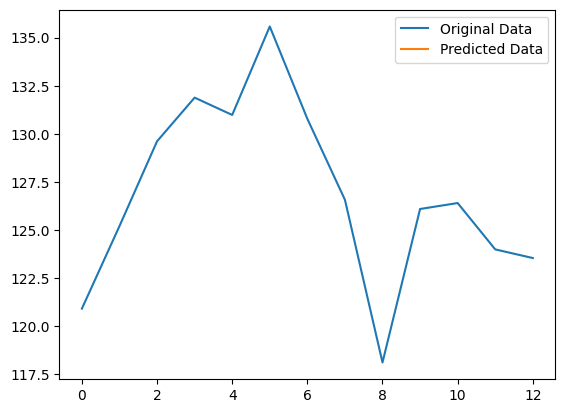

1/1 [==============================] - 0s 22ms/step


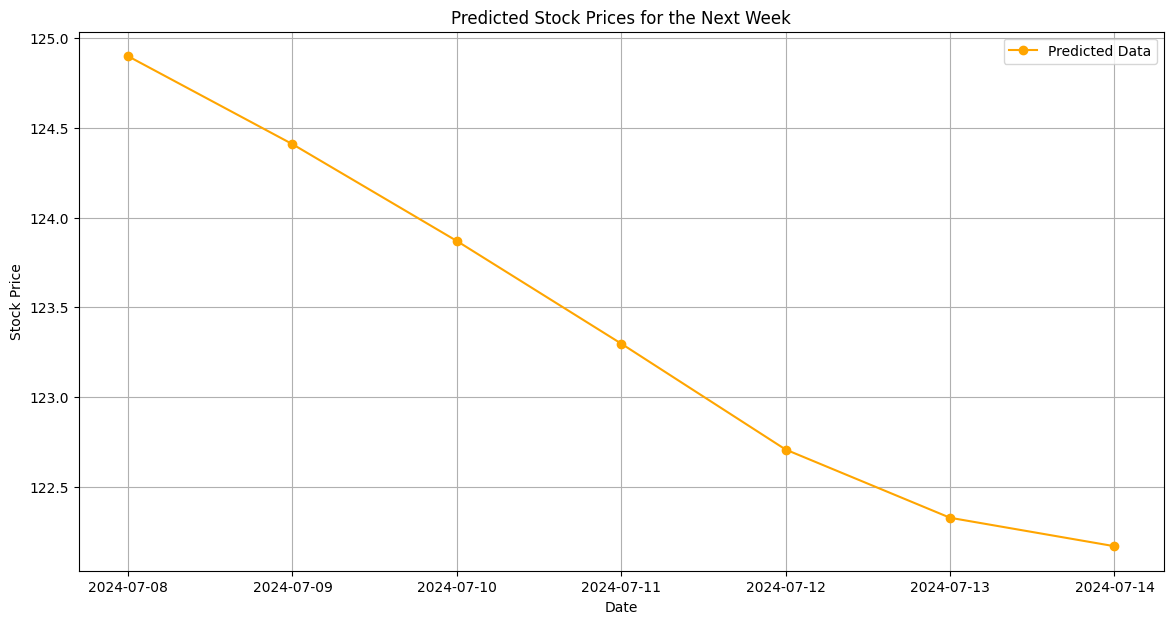

Predicted Opening and Closing Prices for the Next Week:
2024-07-08: Open: 124.90, Close: 124.90
2024-07-09: Open: 124.41, Close: 124.41
2024-07-10: Open: 123.87, Close: 123.87
2024-07-11: Open: 123.30, Close: 123.30
2024-07-12: Open: 122.71, Close: 122.71
2024-07-13: Open: 122.33, Close: 122.33
2024-07-14: Open: 122.17, Close: 122.17


In [28]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

# Download stock data
stock_data = yf.download('NVDA', start='2023-01-01', end='2024-07-01')

# Create additional features
stock_data['MA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20-day moving average
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()  # 50-day moving average

# Drop NaN values created by moving averages
stock_data.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50']].values)

# Create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Check if the dataset is empty
if X.size == 0 or y.size == 0:
    raise ValueError("Not enough data to create the dataset with the given time_step. Please use a smaller time_step.")

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=64))
model.add(Dense(units=1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Predict the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 6))), axis=1))[:, 0]

# Plot the original and predicted data
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Predict the next week's stock prices
X_input = scaled_data[-time_step:].reshape(1, time_step, X.shape[2])
predictions = []

for _ in range(7):
    next_prediction = model.predict(X_input)
    predictions.append(next_prediction[0, 0])
    next_input = np.concatenate((next_prediction, np.zeros((1, 6))), axis=1)
    X_input = np.append(X_input[:, 1:, :], next_input.reshape(1, 1, X.shape[2]), axis=1)

predicted_prices = scaler.inverse_transform(np.concatenate((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), 6))), axis=1))[:, 0]

# Generate dates for the next week
dates = [datetime.now().date() + timedelta(days=i) for i in range(7)]

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, predicted_prices, marker='o', linestyle='-', color='orange', label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Prices for the Next Week')
plt.legend()
plt.grid(True)
plt.show()

# Print the predicted opening and closing prices for each day
print("Predicted Opening and Closing Prices for the Next Week:")
for i, date in enumerate(dates):
    print(f"{date}: Open: {predicted_prices[i]:.2f}, Close: {predicted_prices[i]:.2f}")
